In [ ]:
import random
import numpy as np
import torch
import cv2
import glob
from google.colab import drive
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn, optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from albumentations import Compose, RandomCrop, HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate, Normalize
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

drive.mount('/content/drive')
torch.cuda.is_available()

Mounted at /content/drive


True

In [ ]:
!unzip "drive/MyDrive/datasets/dataset.zip" -d "drive/MyDrive/datasets/"

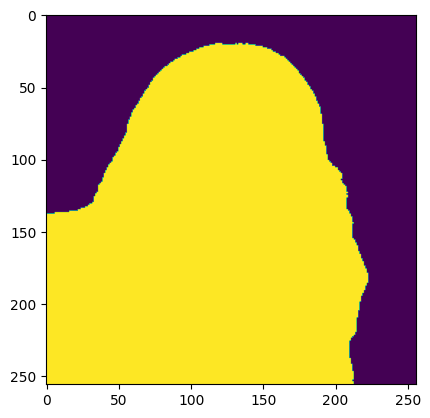

In [ ]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("drive/MyDrive/datasets/dataset/masks/1803151818-00001027.png", cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.resize(img, (256, 256)) > 100)

In [ ]:
import glob

image_files = glob.glob("drive/MyDrive/datasets/dataset/images/*")
masks_files = glob.glob("drive/MyDrive/datasets/dataset/masks/*")

In [ ]:
from torch.utils.data import Dataset
import numpy as np
import torch

class MyDataset(Dataset):
    def __init__(self, imgs_list, masks_list):
        if len(imgs_list) != len(masks_list):
            raise TypeError("Length of images list must be equal to length of masks list!")
        self.imgs = imgs_list
        self.masks = masks_list

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = cv2.imread(self.imgs[idx], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_UNCHANGED)

        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256)) > 100

        mask = torch.Tensor(mask.astype(int))[None, ...]
        img = torch.Tensor(img.copy()).permute(2, 0, 1) / 255.

        return {"image": img, "mask": mask}

In [ ]:
bound = 7 * len(image_files) // 10

train_image_files = image_files[:bound]
train_masks_files = masks_files[:bound]
test_image_files = image_files[bound:]
test_masks_files = masks_files[bound:]

train_dataset = MyDataset(train_image_files, train_masks_files)
test_dataset = MyDataset(test_image_files, test_masks_files)

In [ ]:
from torch import nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

In [ ]:
def jaccard_index(pred, target):
    pred = pred > 0.5
    intersection = torch.sum(pred * target)
    union = torch.sum(pred + target) - intersection
    return (intersection / union).item()

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Let's try to overfit our model on a single batch

In [ ]:
net = UNET(3, 16, 1, 4, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

net = net.cuda()

In [ ]:
net.train()

fixed_batch = next(iter(train_loader))
for epoch in range(400):
    print("epoch:", epoch)
    data = fixed_batch
    x = data['image'].cuda()
    y = data['mask'].cuda()

    optimizer.zero_grad()
    outputs = net(x)

    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}')

epoch: 0
Epoch [1], Loss: 0.7098
epoch: 1
Epoch [2], Loss: 0.6906
epoch: 2
Epoch [3], Loss: 0.6737
epoch: 3
Epoch [4], Loss: 0.6571
epoch: 4
Epoch [5], Loss: 0.6404
epoch: 5
Epoch [6], Loss: 0.6237
epoch: 6
Epoch [7], Loss: 0.6068
epoch: 7
Epoch [8], Loss: 0.5890
epoch: 8
Epoch [9], Loss: 0.5705
epoch: 9
Epoch [10], Loss: 0.5531
epoch: 10
Epoch [11], Loss: 0.5382
epoch: 11
Epoch [12], Loss: 0.5220
epoch: 12
Epoch [13], Loss: 0.5043
epoch: 13
Epoch [14], Loss: 0.4882
epoch: 14
Epoch [15], Loss: 0.4726
epoch: 15
Epoch [16], Loss: 0.4693
epoch: 16
Epoch [17], Loss: 0.4538
epoch: 17
Epoch [18], Loss: 0.4434
epoch: 18
Epoch [19], Loss: 0.4283
epoch: 19
Epoch [20], Loss: 0.4189
epoch: 20
Epoch [21], Loss: 0.4103
epoch: 21
Epoch [22], Loss: 0.3983
epoch: 22
Epoch [23], Loss: 0.3912
epoch: 23
Epoch [24], Loss: 0.3847
epoch: 24
Epoch [25], Loss: 0.3770
epoch: 25
Epoch [26], Loss: 0.3709
epoch: 26
Epoch [27], Loss: 0.3659
epoch: 27
Epoch [28], Loss: 0.3626
epoch: 28
Epoch [29], Loss: 0.3568
epoc

In [ ]:
net.eval()
with torch.no_grad():
    jaccard_scores = []
    data = fixed_batch
    x = data['image'].cuda()
    y = data['mask'].cuda()
    outputs = net(x)
    preds = torch.sigmoid(outputs) > 0.5
    for pred, target in zip(preds, y):
        jaccard_scores.append(jaccard_index(pred, target))

    avg_jaccard = sum(jaccard_scores) / len(jaccard_scores)
    print(f'Average Jaccard Index: {avg_jaccard:.4f}')


Average Jaccard Index: 0.9970


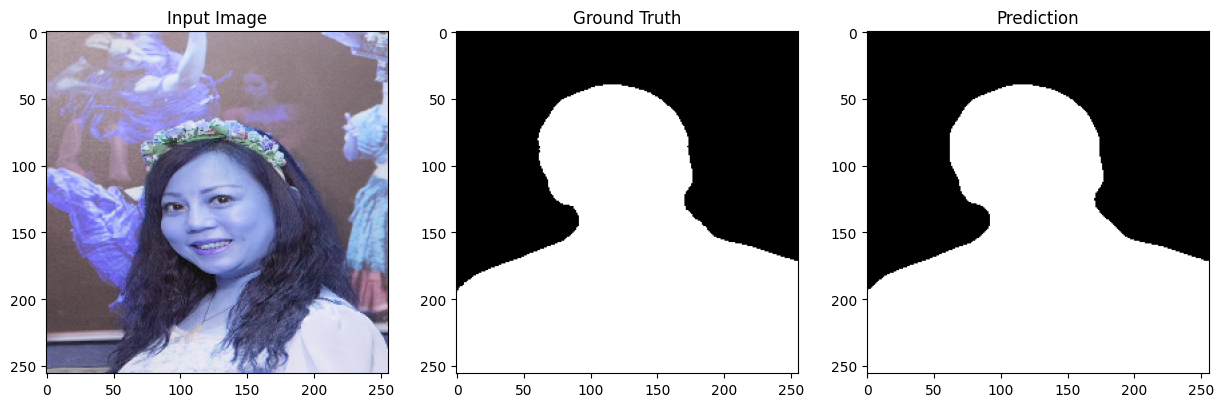

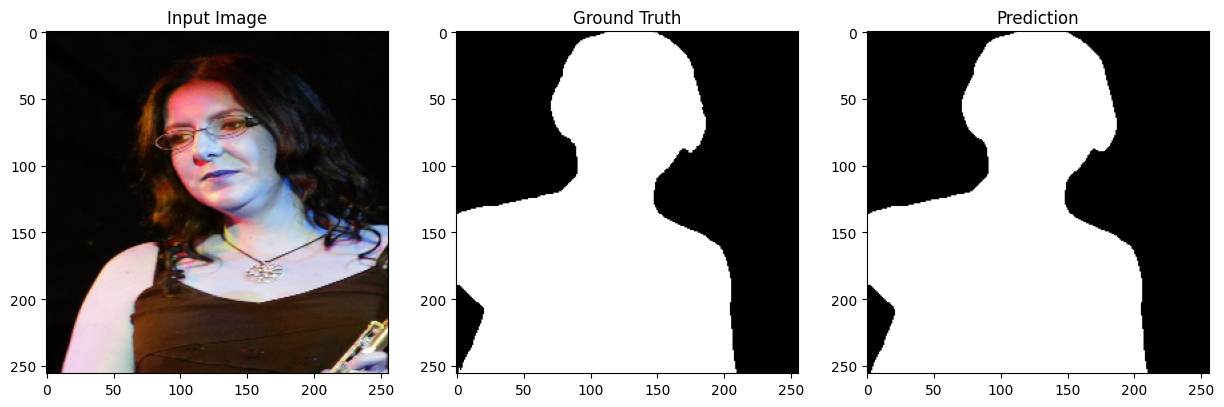

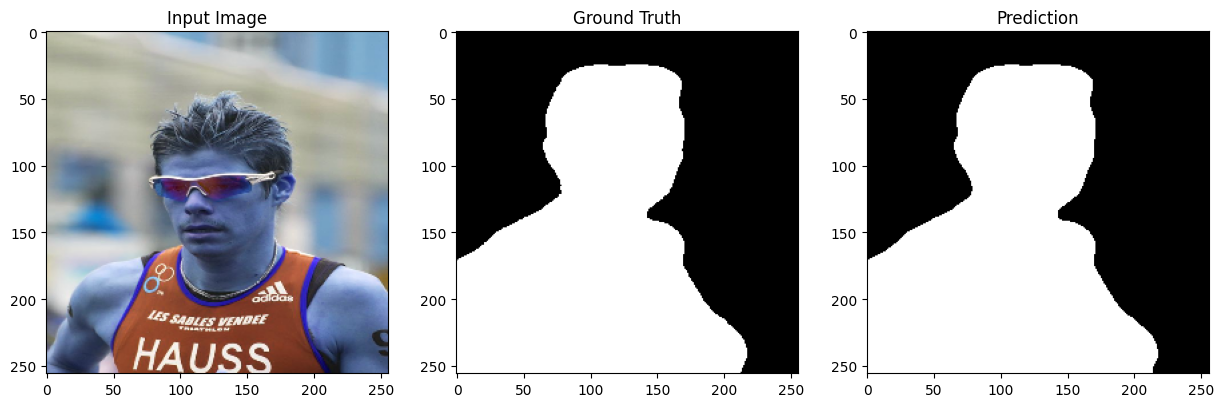

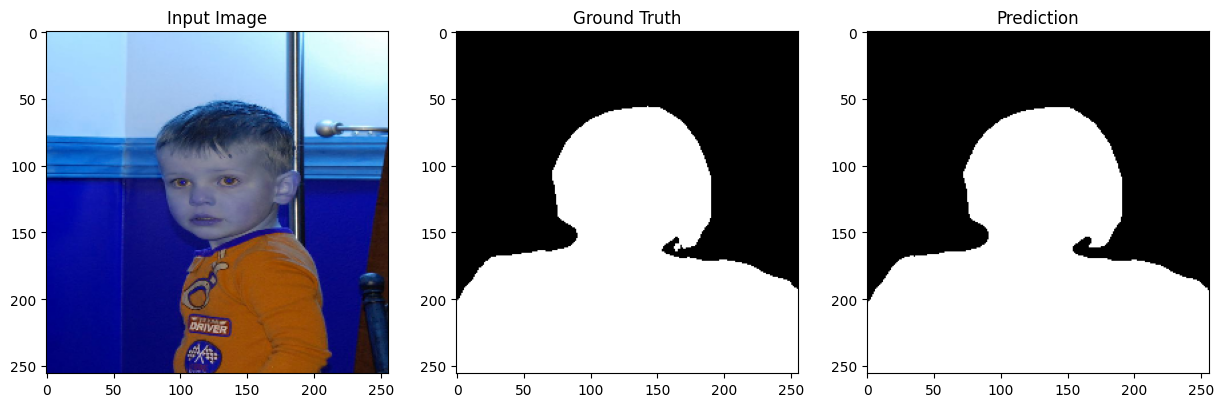

In [ ]:
for i in range(4):
  test_data = {'image': fixed_batch['image'][i], 'mask': fixed_batch['mask'][i]}
  x = test_data['image'][None, ...].cuda()
  y = test_data['mask'][None, ...]

  with torch.no_grad():
      pred = torch.sigmoid(net(x)) > 0.5

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  plt.title('Input Image')
  plt.imshow(x[0].permute(1, 2, 0).cpu())

  plt.subplot(1, 3, 2)
  plt.title('Ground Truth')
  plt.imshow(y[0][0].cpu(), cmap='gray')

  plt.subplot(1, 3, 3)
  plt.title('Prediction')
  plt.imshow(pred[0][0].cpu(), cmap='gray')

  plt.show()

## And measure the quality metric on test dataset

In [ ]:
net.eval()
with torch.no_grad():
    jaccard_scores = []
    for i, data in enumerate(test_loader, 0):
        x = data['image'].cuda()
        y = data['mask'].cuda()
        outputs = net(x)
        preds = torch.sigmoid(outputs) > 0.5
        for pred, target in zip(preds, y):
            jaccard_scores.append(jaccard_index(pred, target))
        if i == 0:
          break

    avg_jaccard = sum(jaccard_scores) / len(jaccard_scores)
    print("-------------------------------")
    print(f'Average Jaccard Index: {avg_jaccard:.4f}')
    print("-------------------------------")


-------------------------------
Average Jaccard Index: 0.4169
-------------------------------


## Train model on whole train dataset

In [ ]:
net = UNET(3, 16, 1, 4, 1)
net = net.cuda()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

num_epochs = 5
train_losses = []
jaccard_indices = []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    jaccard_index_epoch = 0.0

    for i, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        x = data['image'].cuda()
        y = data['mask'].cuda()

        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.sigmoid(outputs) > 0.5
        for pred, target in zip(preds, y):
          jaccard_index_epoch += jaccard_index(pred, target)

    train_loss = running_loss / len(train_loader)
    jaccard_index_epoch = jaccard_index_epoch / len(train_loader.dataset)

    train_losses.append(train_loss)
    jaccard_indices.append(jaccard_index_epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Jaccard Index: {jaccard_index_epoch:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/350 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/5], Loss: 0.4131, Jaccard Index: 0.7166


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [2/5], Loss: 0.3237, Jaccard Index: 0.7693


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [3/5], Loss: 0.3115, Jaccard Index: 0.7717


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [4/5], Loss: 0.3077, Jaccard Index: 0.7717


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [5/5], Loss: 0.3069, Jaccard Index: 0.7721


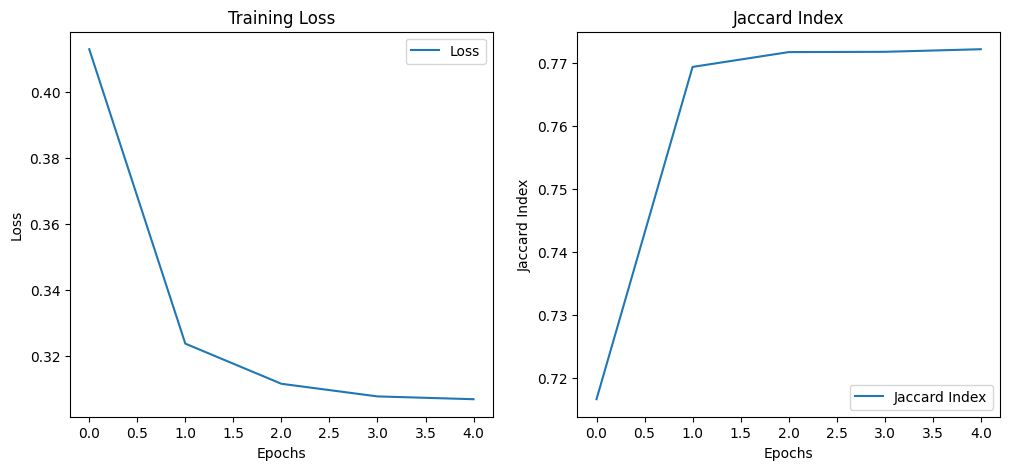

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(jaccard_indices, label="Jaccard Index")
plt.xlabel("Epochs")
plt.ylabel("Jaccard Index")
plt.title("Jaccard Index")
plt.legend()

plt.show()

  0%|          | 0/600 [00:00<?, ?it/s]

Jaccard index: 0.76668259943525


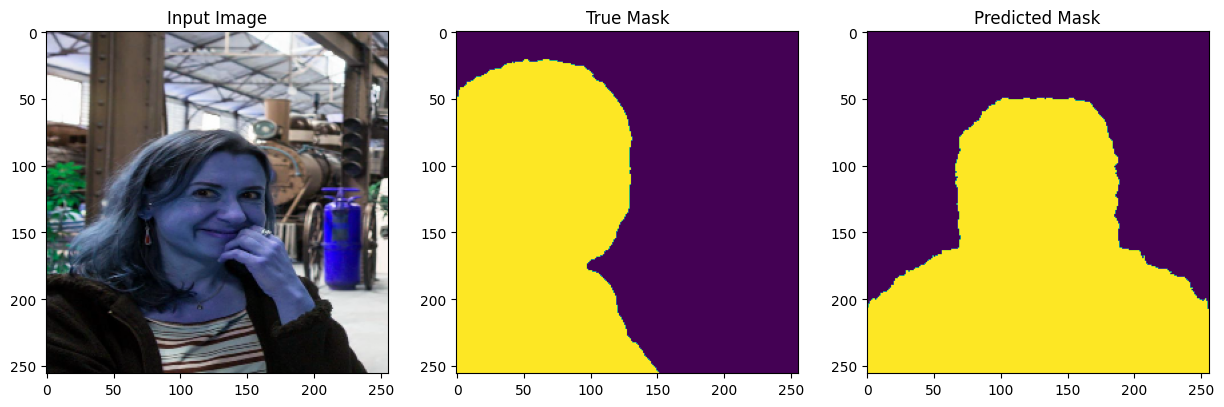

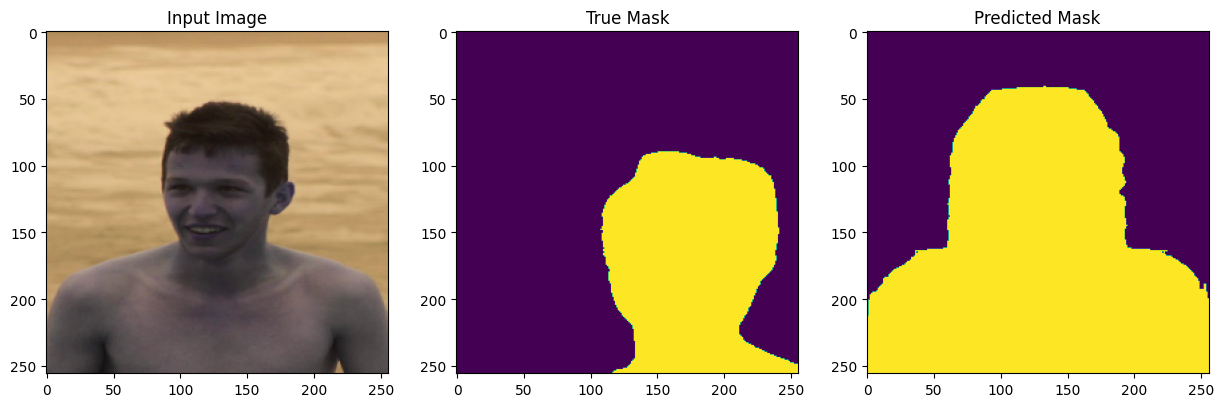

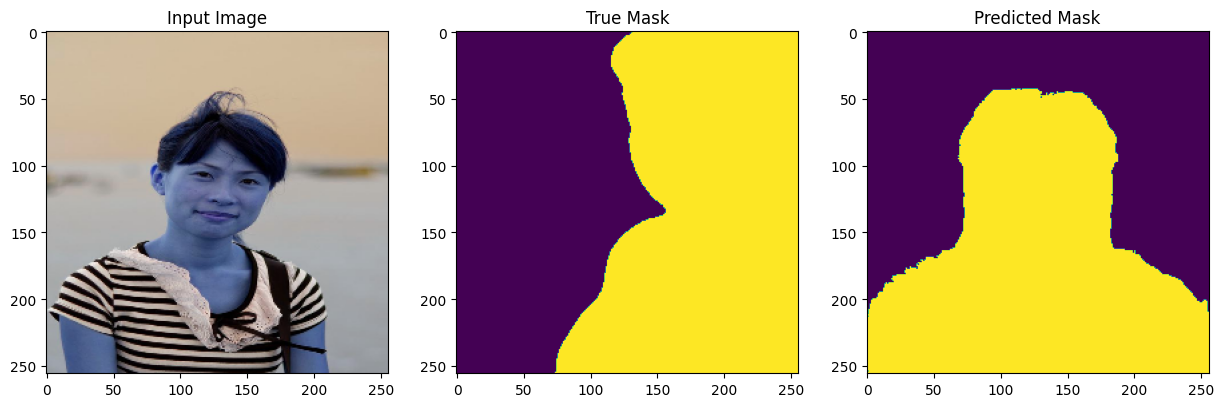

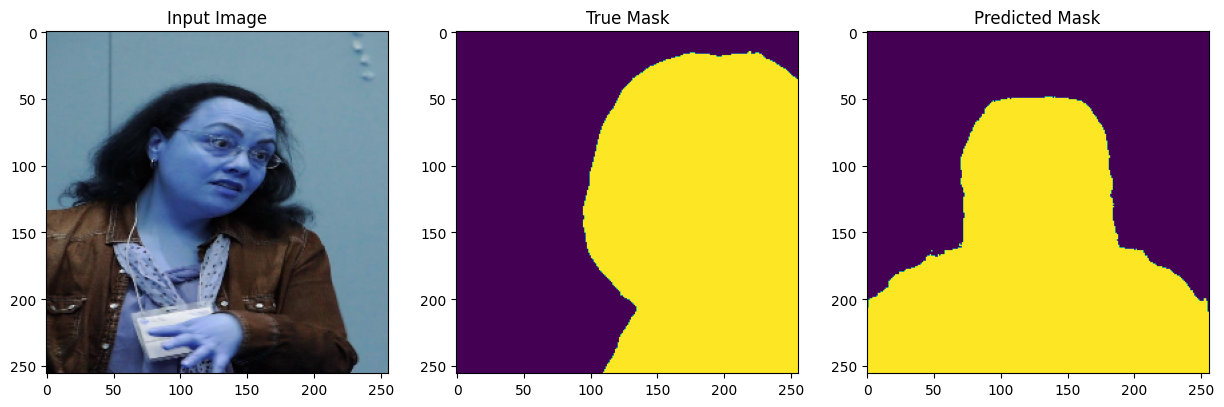

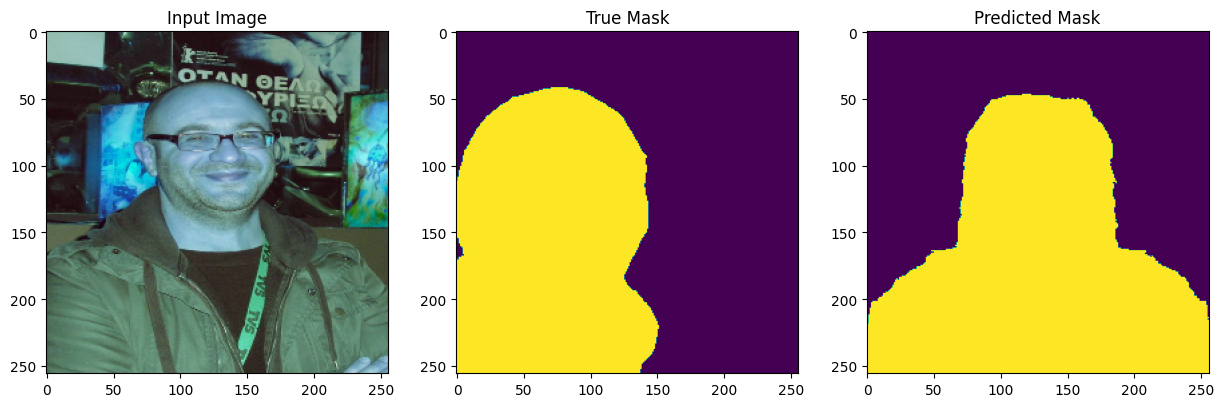

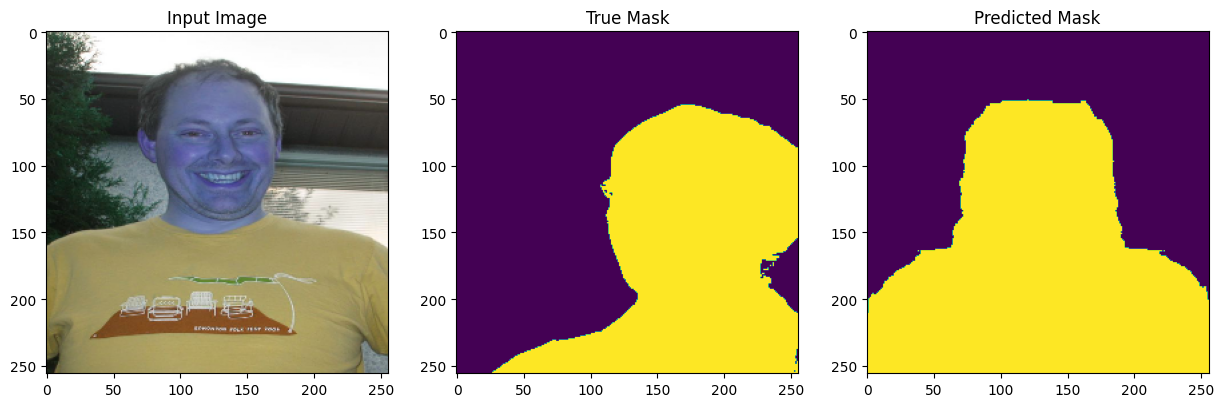

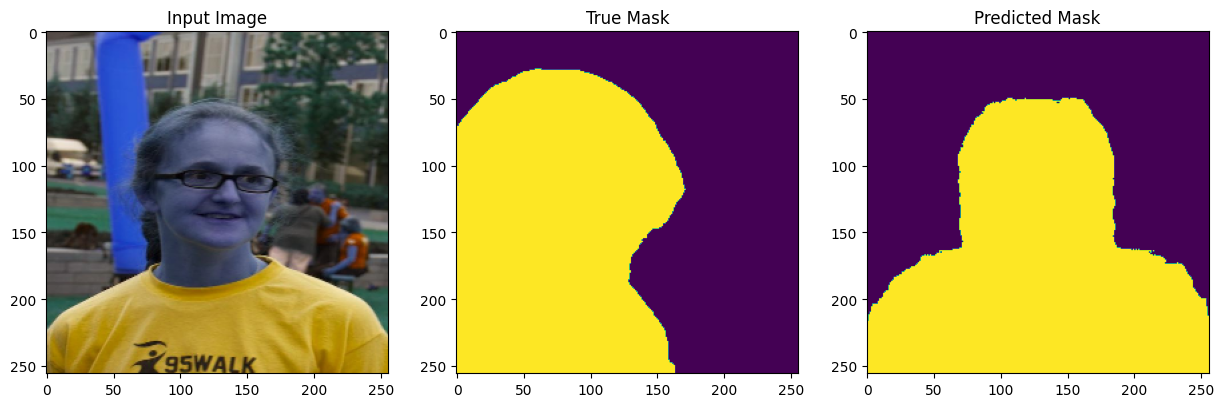

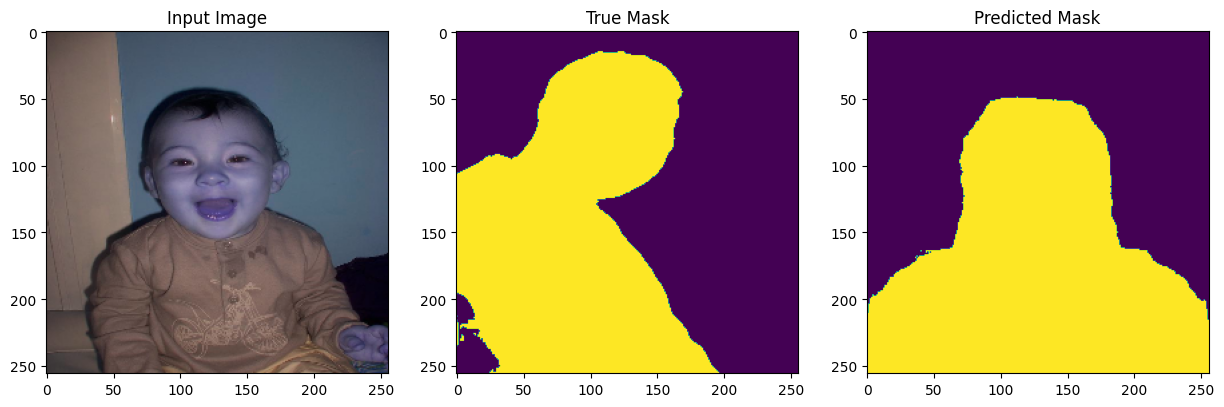

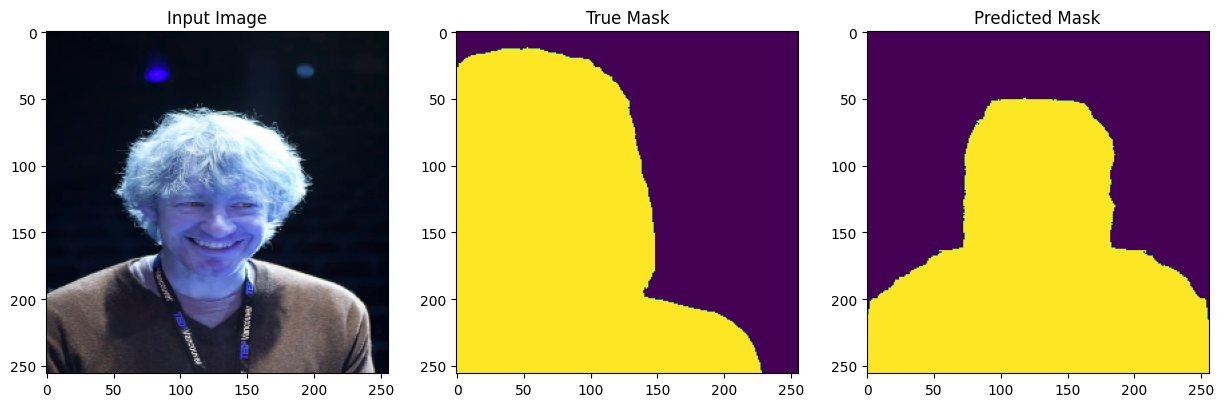

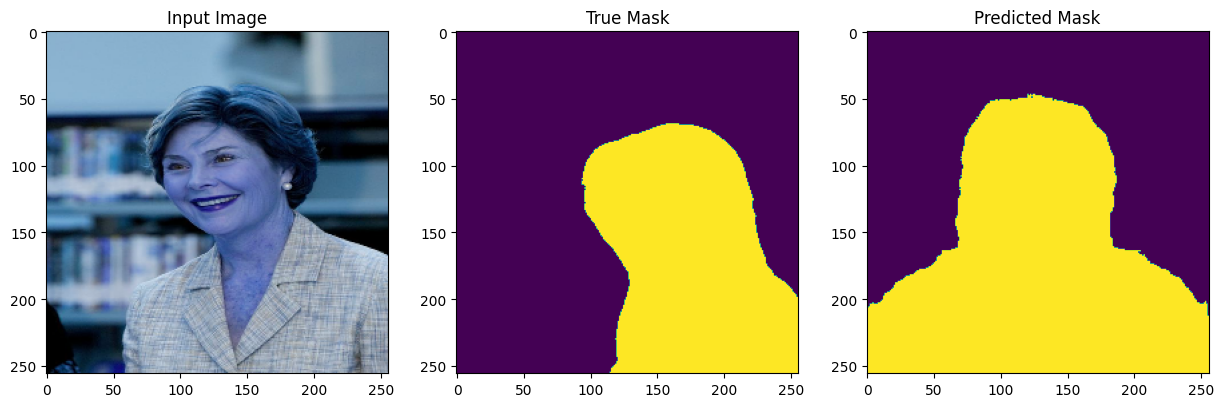

In [ ]:
net.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
errors = []

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader, 0), total=len(test_loader)):
        x = data['image'].cuda()
        y = data['mask'].cuda()
        outputs = net(x)
        preds = torch.sigmoid(outputs) > 0.5
        errors.append((jaccard_index(preds, y), i, x.cpu(), y.cpu(), preds.cpu()))

print(f"Jaccard index: {np.mean(list(map(lambda x: x[0], errors)))}")
errors = sorted(errors, key=lambda x: x[0])
topN = 10

for i in range(topN):
    _, idx, x, y, preds = errors[i]
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(x[0].permute(1, 2, 0))

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(y[0].permute(1, 2, 0))

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(preds[0][0].numpy() > 0)

    plt.show()

In [ ]:
import albumentations as A
from PIL import Image
from albumentations.pytorch import ToTensorV2

class AugDataset(Dataset):
    def __init__(self, imgs_list, masks_list, augmentations=None):
        if len(imgs_list) != len(masks_list):
            raise TypeError("Length of images list must be equal to length of masks list!")
        self.imgs = imgs_list
        self.masks = masks_list
        self.augmentations = augmentations

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = cv2.imread(self.imgs[idx], cv2.IMREAD_COLOR)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        if self.augmentations:
            augmented = self.augmentations(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        else:
            mask = torch.tensor(mask)
            img = torch.tensor(img)

        mask = (mask > 100).float()
        mask = mask.unsqueeze(0)

        return {"image": img, "mask": mask}

train_transforms = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=0.5),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

train_dataset = AugDataset(image_files[:bound], masks_files[:bound], augmentations=train_transforms)
test_dataset = AugDataset(image_files[bound:], masks_files[bound:])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

net = UNET(3, 16, 1, 4, 1)

criterion = nn.BCEWithLogitsLoss()
net = net.cuda()

optimizer = optim.AdamW(net.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

for epoch in range(5):
    print("epoch:", epoch)
    net.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader)):
        x = data['image']
        y = data['mask']

        optimizer.zero_grad()
        outputs = net(x.cuda())
        loss = criterion(outputs, y.cuda())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print(epoch + 1, i + 1, running_loss / 10)
            running_loss = 0.0

    scheduler.step(running_loss)

epoch: 0


0it [00:00, ?it/s]

1 10 0.718942791223526
1 20 0.692273074388504
1 30 0.6985124111175537
1 40 0.6814678728580474
1 50 0.6749011695384979
1 60 0.6650859236717224
1 70 0.6824593424797059
1 80 0.6691522657871246
1 90 0.6304346859455109
1 100 0.6389601349830627
1 110 0.6162219703197479
1 120 0.623122262954712
1 130 0.613010972738266
1 140 0.6051172912120819
1 150 0.6108160495758057
1 160 0.603121531009674
1 170 0.6142483234405518
1 180 0.6079668819904327
1 190 0.5851698458194733
1 200 0.6108003735542298
1 210 0.5714404463768006
1 220 0.599729374051094
1 230 0.5954591333866119
1 240 0.5838832557201385
1 250 0.5769606530666351
1 260 0.555948543548584
1 270 0.586378014087677
1 280 0.5873233377933502
1 290 0.5716437637805939
1 300 0.6054933667182922
1 310 0.5733631134033204
1 320 0.5713491559028625
1 330 0.5582333743572235
1 340 0.5840647041797637
1 350 0.5787255644798279
epoch: 1


0it [00:00, ?it/s]

2 10 0.5566957235336304
2 20 0.5498398989439011
2 30 0.553896301984787
2 40 0.5704157590866089
2 50 0.5613841474056244
2 60 0.5381830871105194
2 70 0.5472927808761596
2 80 0.529650890827179
2 90 0.5361618280410767
2 100 0.5569198966026306
2 110 0.51540467441082
2 120 0.5433914303779602
2 130 0.5692870080471039
2 140 0.5300343036651611
2 150 0.5555134922266006
2 160 0.5413687944412231
2 170 0.5539971649646759
2 180 0.5383514732122421
2 190 0.5690935909748077
2 200 0.5457688063383103
2 210 0.5632366836071014
2 220 0.5537956893444062
2 230 0.5632467150688172
2 240 0.5814883947372437
2 250 0.5282997637987137
2 260 0.5323150157928467
2 270 0.5297783732414245
2 280 0.5384789168834686
2 290 0.5219243764877319
2 300 0.5151238411664962
2 310 0.5372841745615006
2 320 0.5352251976728439
2 330 0.5437039971351624
2 340 0.5175899386405944
2 350 0.5649570554494858
epoch: 2


0it [00:00, ?it/s]

3 10 0.5297945380210877
3 20 0.5383803367614746
3 30 0.5681675493717193
3 40 0.523313707113266
3 50 0.5270477771759033
3 60 0.5073769271373749
3 70 0.5101505070924759
3 80 0.5081531077623367
3 90 0.5347267657518386
3 100 0.5119127243757248
3 110 0.5151699990034103
3 120 0.5408310472965241
3 130 0.49164372086524966
3 140 0.5368794858455658
3 150 0.5281388819217682
3 160 0.5308597803115844
3 170 0.5581014037132264
3 180 0.4960660994052887
3 190 0.5126812905073166
3 200 0.5307623118162155
3 210 0.4900406152009964
3 220 0.4921936482191086
3 230 0.5098608523607254
3 240 0.5273284405469895
3 250 0.49275830388069153
3 260 0.5286990255117416
3 270 0.5041105061769485
3 280 0.5143770396709442
3 290 0.4933187663555145
3 300 0.5267819792032242
3 310 0.5448837965726853
3 320 0.5371313571929932
3 330 0.5590331345796585
3 340 0.4915324956178665
3 350 0.5128605604171753
epoch: 3


0it [00:00, ?it/s]

4 10 0.4638978898525238
4 20 0.5529262691736221
4 30 0.5361676007509232
4 40 0.49330187737941744
4 50 0.4933214157819748
4 60 0.5287620723247528
4 70 0.5241553694009781
4 80 0.5517183303833008
4 90 0.5109365195035934
4 100 0.5042291760444642
4 110 0.5035287648439407
4 120 0.49660578072071077
4 130 0.5198623389005661
4 140 0.5165887951850892
4 150 0.5112501859664917
4 160 0.5152682960033417
4 170 0.49952746033668516
4 180 0.5439557164907456
4 190 0.5005022555589675
4 200 0.4964007824659348
4 210 0.49207196831703187
4 220 0.4734891355037689
4 230 0.485642871260643
4 240 0.5299766540527344
4 250 0.5261250108480453
4 260 0.49213354885578153
4 270 0.461893567442894
4 280 0.5197445303201675
4 290 0.48703118562698366
4 300 0.4873580694198608
4 310 0.4980244994163513
4 320 0.4891483008861542
4 330 0.5035945355892182
4 340 0.5296037197113037
4 350 0.48958627581596376
epoch: 4


0it [00:00, ?it/s]

5 10 0.489898544549942
5 20 0.510304594039917
5 30 0.49081301391124726
5 40 0.49392137825489046
5 50 0.4731023579835892
5 60 0.5049952298402787
5 70 0.5586059242486954
5 80 0.4916816413402557
5 90 0.5186009407043457
5 100 0.4991369366645813
5 110 0.4874476730823517
5 120 0.48887009620666505
5 130 0.4731865435838699
5 140 0.4852754235267639
5 150 0.4687663555145264
5 160 0.476647412776947
5 170 0.4932736247777939
5 180 0.4901444613933563
5 190 0.5049526333808899
5 200 0.5119420260190963
5 210 0.4833862155675888
5 220 0.4966425716876984
5 230 0.5275923401117325
5 240 0.5045093536376953
5 250 0.4914416879415512
5 260 0.4665237993001938
5 270 0.45848502218723297
5 280 0.4889571279287338
5 290 0.4792957603931427
5 300 0.46032841205596925
5 310 0.46644134521484376
5 320 0.5182737469673157
5 330 0.5019831329584121
5 340 0.4870651036500931
5 350 0.5072453856468201


In [ ]:
# Без аугментаций
test_transforms = Compose([
    Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

test_dataset = AugDataset(image_files[-250:], masks_files[-250:], augmentations=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

net.eval()
with torch.no_grad():
    jaccard_scores = []
    for data in tqdm(test_loader):
        x = data['image'].cuda()
        y = data['mask'].cuda()
        outputs = net(x)
        preds = torch.sigmoid(outputs) > 0.5
        jaccard_scores.append(jaccard_index(preds, y))

    avg_jaccard = sum(jaccard_scores) / len(jaccard_scores)
    print("---------------------")
    print(f'Average Jaccard Index without augmentations: {avg_jaccard:.4f}')
    print("---------------------")

# С аугментацией HorizontalFlip
test_transforms = Compose([
    HorizontalFlip(p=1.0),
    Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

test_dataset = AugDataset(image_files[-250:], masks_files[-250:], augmentations=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

net.eval()
with torch.no_grad():
    jaccard_scores = []
    for data in tqdm(test_loader):
        x = data['image'].cuda()
        y = data['mask'].cuda()
        outputs = net(x)
        preds = torch.sigmoid(outputs) > 0.5
        jaccard_scores.append(jaccard_index(preds, y))

    avg_jaccard = sum(jaccard_scores) / len(jaccard_scores)
    print("---------------------")
    print(f'Average Jaccard Index with HorizontalFlip augmentation: {avg_jaccard:.4f}')
    print("---------------------")

  0%|          | 0/250 [00:00<?, ?it/s]

---------------------
Average Jaccard Index without augmentations: 0.6767
---------------------


  0%|          | 0/250 [00:00<?, ?it/s]

---------------------
Average Jaccard Index with HorizontalFlip augmentation: 0.6771
---------------------


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def train_and_evaluate(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
            x = data['image'].cuda()
            y = data['mask'].cuda()

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 10:.4f}")
                running_loss = 0.0

        scheduler.step(running_loss)

    model.eval()
    jaccard_scores = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            x = data['image'].cuda()
            y = data['mask'].cuda()
            outputs = model(x)
            preds = torch.sigmoid(outputs) > 0.5
            jaccard_scores.extend([jaccard_index(pred, target) for pred, target in zip(preds, y)])

    avg_jaccard = sum(jaccard_scores) / len(jaccard_scores)
    return avg_jaccard


## Let's change UNET architecture and use ResNetEncoder

In [ ]:
class UNetWithResNetEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super(UNetWithResNetEncoder, self).__init__()
        self.encoder = models.resnet18(pretrained=pretrained)

        self.encoder_layers = list(self.encoder.children())
        self.layer0 = nn.Sequential(*self.encoder_layers[:3])  # до maxpooling
        self.layer1 = nn.Sequential(*self.encoder_layers[3:5])  # maxpooling + первый блок
        self.layer2 = self.encoder_layers[5]  # второй блок
        self.layer3 = self.encoder_layers[6]  # третий блок
        self.layer4 = self.encoder_layers[7]  # четвертый блок

        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upsample4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.decoder4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.final_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc0 = self.layer0(x)
        enc1 = self.layer1(enc0)
        enc2 = self.layer2(enc1)
        enc3 = self.layer3(enc2)
        enc4 = self.layer4(enc3)

        # Decoder
        dec1 = self.upsample1(enc4)
        dec1 = torch.cat((dec1, enc3), dim=1)
        dec1 = self.decoder1(dec1)

        dec2 = self.upsample2(dec1)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec3 = self.upsample3(dec2)
        dec3 = torch.cat((dec3, enc1), dim=1)
        dec3 = self.decoder3(dec3)

        dec4 = self.upsample4(dec3)
        dec4 = torch.cat((dec4, enc0), dim=1)
        dec4 = self.decoder4(dec4)

        return self.final_layer(dec4)

In [ ]:


def train_and_evaluate(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
            x = data['image'].cuda()
            y = data['mask'].cuda()

            optimizer.zero_grad()
            outputs = model(x)
            outputs = nn.functional.interpolate(outputs, size=y.shape[2:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 10:.4f}")
                running_loss = 0.0

        scheduler.step(running_loss)

    model.eval()
    jaccard_scores = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            x = data['image'].cuda()
            y = data['mask'].cuda()
            outputs = model(x)
            outputs = nn.functional.interpolate(outputs, size=y.shape[2:], mode='bilinear', align_corners=False)
            preds = torch.sigmoid(outputs) > 0.5
            jaccard_scores.extend([jaccard_index(pred, target) for pred, target in zip(preds, y)])

    avg_jaccard = sum(jaccard_scores) / len(jaccard_scores)
    return avg_jaccard


In [ ]:
import copy

train_transforms = Compose([
    RandomCrop(width=256, height=256),
    RandomRotate90(p=0.5),
    ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=0.5),
    Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

test_transforms = Compose([
    RandomCrop(width=256, height=256),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.1),
    RandomRotate90(p=0.5),
    ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=0.5),
    Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

bound = 7 * len(image_files) // 10
dataset = AugDataset(image_files[:bound], masks_files[:bound], augmentations=train_transforms)
test_dataset = AugDataset(image_files[bound:], masks_files[bound:], augmentations=test_transforms)
test_dataset = AugDataset(image_files[bound:], masks_files[bound:], augmentations=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

criterion = nn.BCEWithLogitsLoss()
num_epochs = 5
batch_size = 4

results = []

best_model_wts = None
best_jaccard = 0
fold = 0
print(f"Fold {fold + 1}")

train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=8)
valid_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)

model = UNetWithResNetEncoder().cuda()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

avg_jaccard = train_and_evaluate(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs)
print(f"Jaccard Index: {avg_jaccard:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can als

Fold 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [1/5], Step [10/350], Loss: 0.6939
Epoch [1/5], Step [20/350], Loss: 0.6870
Epoch [1/5], Step [30/350], Loss: 0.6683
Epoch [1/5], Step [40/350], Loss: 0.5852
Epoch [1/5], Step [50/350], Loss: 0.5298
Epoch [1/5], Step [60/350], Loss: 0.4754
Epoch [1/5], Step [70/350], Loss: 0.4510
Epoch [1/5], Step [80/350], Loss: 0.4520
Epoch [1/5], Step [90/350], Loss: 0.4823
Epoch [1/5], Step [100/350], Loss: 0.4367
Epoch [1/5], Step [110/350], Loss: 0.4248
Epoch [1/5], Step [120/350], Loss: 0.3664
Epoch [1/5], Step [130/350], Loss: 0.4265
Epoch [1/5], Step [140/350], Loss: 0.4541
Epoch [1/5], Step [150/350], Loss: 0.3900
Epoch [1/5], Step [160/350], Loss: 0.4362
Epoch [1/5], Step [170/350], Loss: 0.3744
Epoch [1/5], Step [180/350], Loss: 0.3980
Epoch [1/5], Step [190/350], Loss: 0.4012
Epoch [1/5], Step [200/350], Loss: 0.3987
Epoch [1/5], Step [210/350], Loss: 0.4081
Epoch [1/5], Step [220/350], Loss: 0.4116
Epoch [1/5], Step [230/350], Loss: 0.4214
Epoch [1/5], Step [240/350], Loss: 0.3509
E

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/5], Step [350/350], Loss: 0.4105


  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [2/5], Step [10/350], Loss: 0.3802
Epoch [2/5], Step [20/350], Loss: 0.3963
Epoch [2/5], Step [30/350], Loss: 0.4203
Epoch [2/5], Step [40/350], Loss: 0.4141
Epoch [2/5], Step [50/350], Loss: 0.3735
Epoch [2/5], Step [60/350], Loss: 0.3400
Epoch [2/5], Step [70/350], Loss: 0.3496
Epoch [2/5], Step [80/350], Loss: 0.4155
Epoch [2/5], Step [90/350], Loss: 0.4014
Epoch [2/5], Step [100/350], Loss: 0.3721
Epoch [2/5], Step [110/350], Loss: 0.3453
Epoch [2/5], Step [120/350], Loss: 0.3375
Epoch [2/5], Step [130/350], Loss: 0.3560
Epoch [2/5], Step [140/350], Loss: 0.4007
Epoch [2/5], Step [150/350], Loss: 0.3676
Epoch [2/5], Step [160/350], Loss: 0.3429
Epoch [2/5], Step [170/350], Loss: 0.3358
Epoch [2/5], Step [180/350], Loss: 0.3436
Epoch [2/5], Step [190/350], Loss: 0.3557
Epoch [2/5], Step [200/350], Loss: 0.3840
Epoch [2/5], Step [210/350], Loss: 0.3683
Epoch [2/5], Step [220/350], Loss: 0.3754
Epoch [2/5], Step [230/350], Loss: 0.3675
Epoch [2/5], Step [240/350], Loss: 0.3508
E

  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [3/5], Step [10/350], Loss: 0.3675
Epoch [3/5], Step [20/350], Loss: 0.3839
Epoch [3/5], Step [30/350], Loss: 0.3610
Epoch [3/5], Step [40/350], Loss: 0.3594
Epoch [3/5], Step [50/350], Loss: 0.3115
Epoch [3/5], Step [60/350], Loss: 0.3126
Epoch [3/5], Step [70/350], Loss: 0.3310
Epoch [3/5], Step [80/350], Loss: 0.4158
Epoch [3/5], Step [90/350], Loss: 0.3817
Epoch [3/5], Step [100/350], Loss: 0.3500
Epoch [3/5], Step [110/350], Loss: 0.3323
Epoch [3/5], Step [120/350], Loss: 0.3074
Epoch [3/5], Step [130/350], Loss: 0.3644
Epoch [3/5], Step [140/350], Loss: 0.3870
Epoch [3/5], Step [150/350], Loss: 0.3426
Epoch [3/5], Step [160/350], Loss: 0.3340
Epoch [3/5], Step [170/350], Loss: 0.3263
Epoch [3/5], Step [180/350], Loss: 0.3333
Epoch [3/5], Step [190/350], Loss: 0.3635
Epoch [3/5], Step [200/350], Loss: 0.3406
Epoch [3/5], Step [210/350], Loss: 0.3567
Epoch [3/5], Step [220/350], Loss: 0.3514
Epoch [3/5], Step [230/350], Loss: 0.3303
Epoch [3/5], Step [240/350], Loss: 0.3407
E

  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [4/5], Step [10/350], Loss: 0.3347
Epoch [4/5], Step [20/350], Loss: 0.3566
Epoch [4/5], Step [30/350], Loss: 0.3595
Epoch [4/5], Step [40/350], Loss: 0.3367
Epoch [4/5], Step [50/350], Loss: 0.3099
Epoch [4/5], Step [60/350], Loss: 0.3132
Epoch [4/5], Step [70/350], Loss: 0.3399
Epoch [4/5], Step [80/350], Loss: 0.3755
Epoch [4/5], Step [90/350], Loss: 0.3430
Epoch [4/5], Step [100/350], Loss: 0.3261
Epoch [4/5], Step [110/350], Loss: 0.3223
Epoch [4/5], Step [120/350], Loss: 0.3106
Epoch [4/5], Step [130/350], Loss: 0.3713
Epoch [4/5], Step [140/350], Loss: 0.3717
Epoch [4/5], Step [150/350], Loss: 0.3382
Epoch [4/5], Step [160/350], Loss: 0.3272
Epoch [4/5], Step [170/350], Loss: 0.3178
Epoch [4/5], Step [180/350], Loss: 0.3348
Epoch [4/5], Step [190/350], Loss: 0.3376
Epoch [4/5], Step [200/350], Loss: 0.3263
Epoch [4/5], Step [210/350], Loss: 0.3353
Epoch [4/5], Step [220/350], Loss: 0.3614
Epoch [4/5], Step [230/350], Loss: 0.3302
Epoch [4/5], Step [240/350], Loss: 0.3142
E

  0%|          | 0/350 [00:00<?, ?it/s]

Epoch [5/5], Step [10/350], Loss: 0.3179
Epoch [5/5], Step [20/350], Loss: 0.3626
Epoch [5/5], Step [30/350], Loss: 0.3421
Epoch [5/5], Step [40/350], Loss: 0.3153
Epoch [5/5], Step [50/350], Loss: 0.2971
Epoch [5/5], Step [60/350], Loss: 0.2928
Epoch [5/5], Step [70/350], Loss: 0.3046
Epoch [5/5], Step [80/350], Loss: 0.3983
Epoch [5/5], Step [90/350], Loss: 0.3719
Epoch [5/5], Step [100/350], Loss: 0.3118
Epoch [5/5], Step [110/350], Loss: 0.3051
Epoch [5/5], Step [120/350], Loss: 0.2986
Epoch [5/5], Step [130/350], Loss: 0.3412
Epoch [5/5], Step [140/350], Loss: 0.3710
Epoch [5/5], Step [150/350], Loss: 0.3306
Epoch [5/5], Step [160/350], Loss: 0.3011
Epoch [5/5], Step [170/350], Loss: 0.2741
Epoch [5/5], Step [180/350], Loss: 0.2850
Epoch [5/5], Step [190/350], Loss: 0.3304
Epoch [5/5], Step [200/350], Loss: 0.3341
Epoch [5/5], Step [210/350], Loss: 0.3233
Epoch [5/5], Step [220/350], Loss: 0.3379
Epoch [5/5], Step [230/350], Loss: 0.3158
Epoch [5/5], Step [240/350], Loss: 0.3056
E

  0%|          | 0/150 [00:00<?, ?it/s]

Jaccard Index: 0.7270


  0%|          | 0/600 [00:00<?, ?it/s]

Jaccard Index: 0.7262


  0%|          | 0/10 [00:00<?, ?it/s]

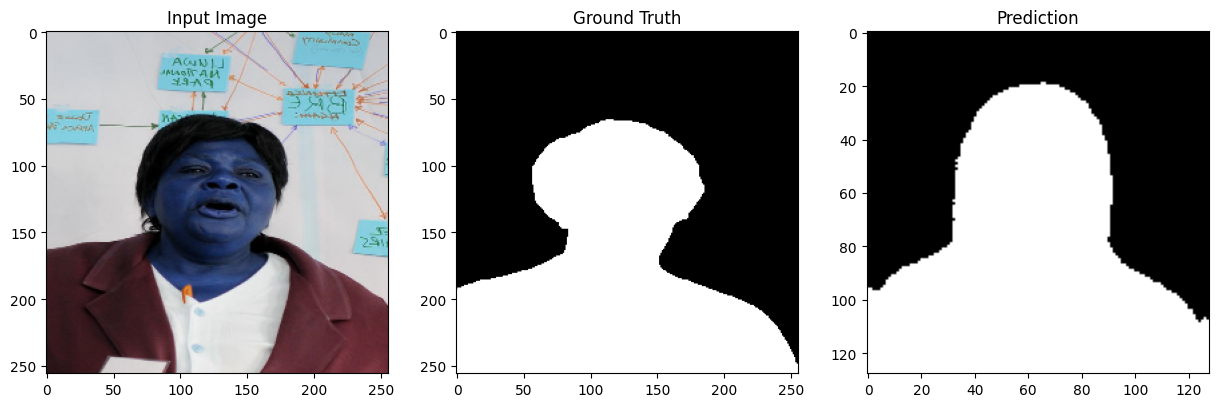

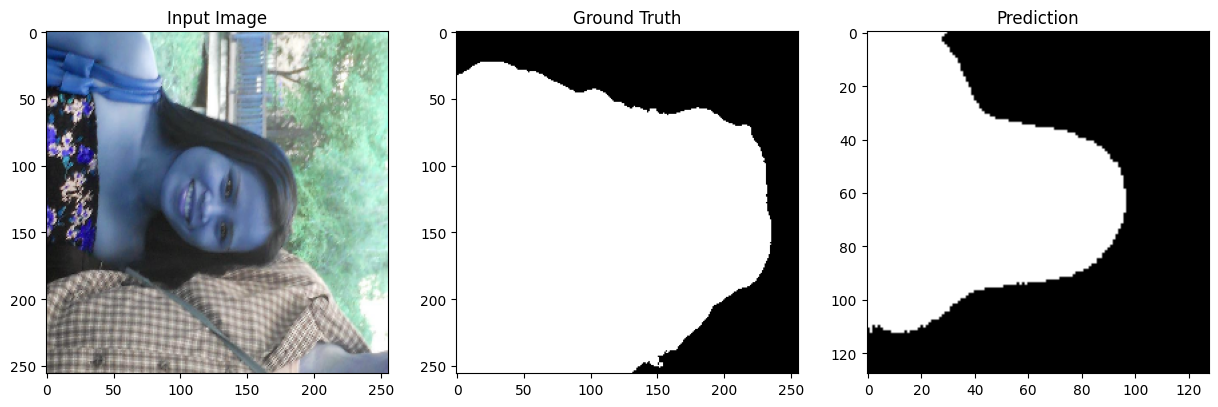

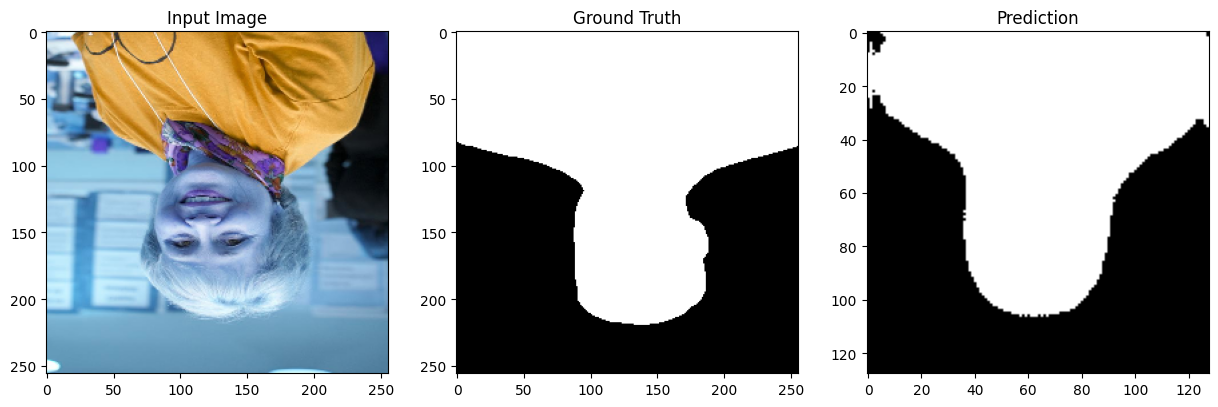

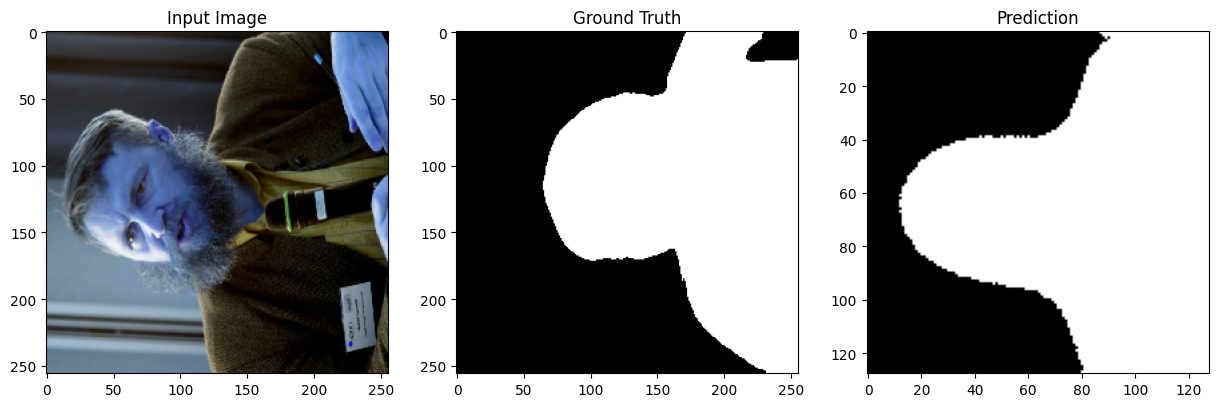

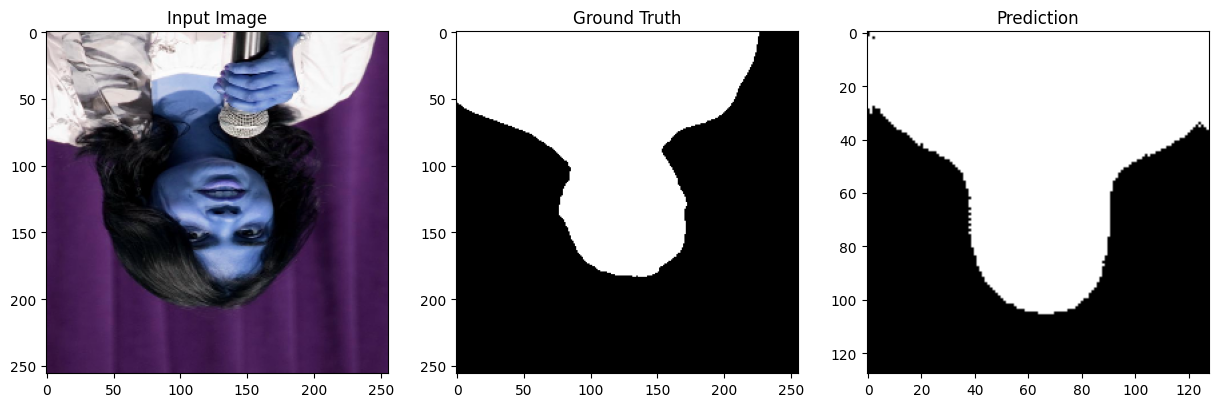

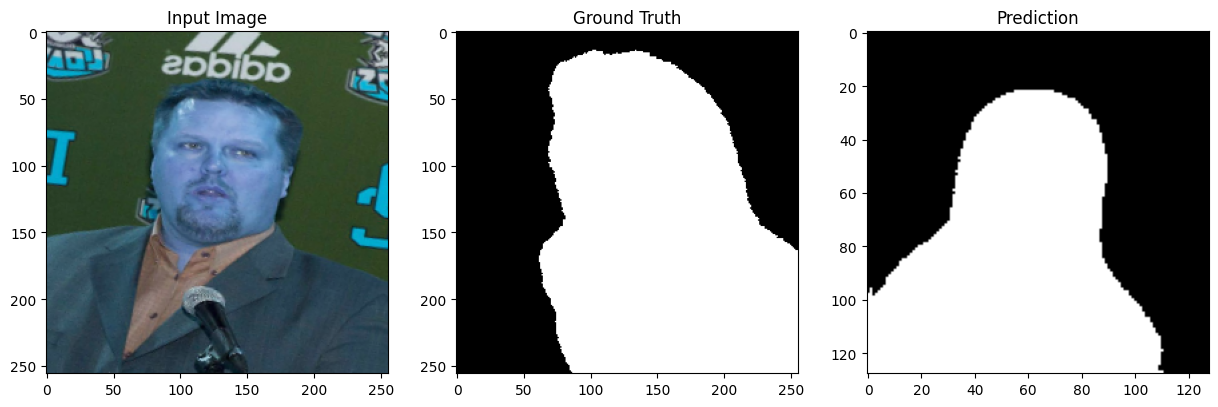

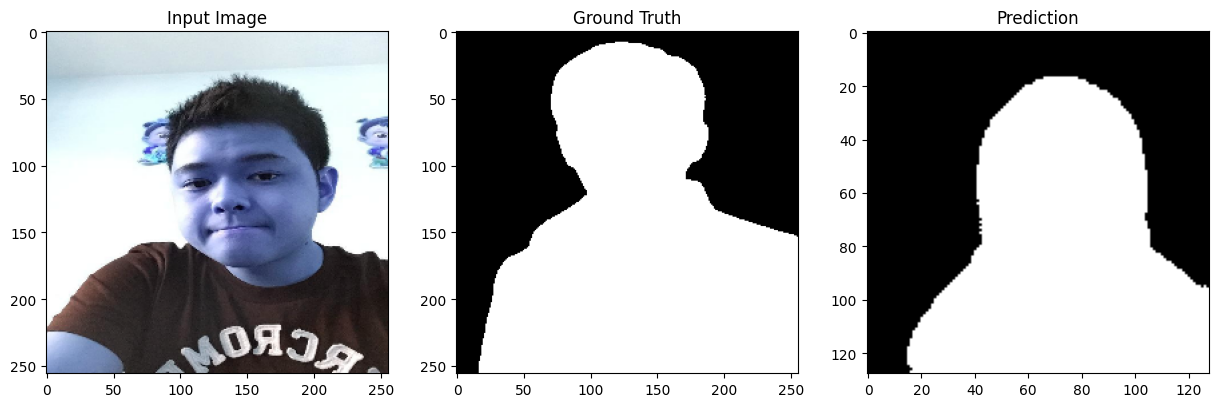

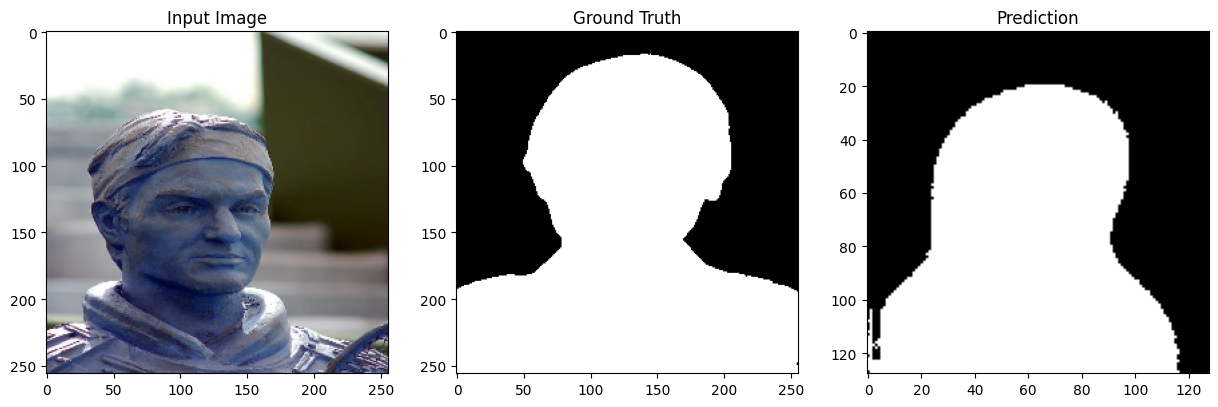

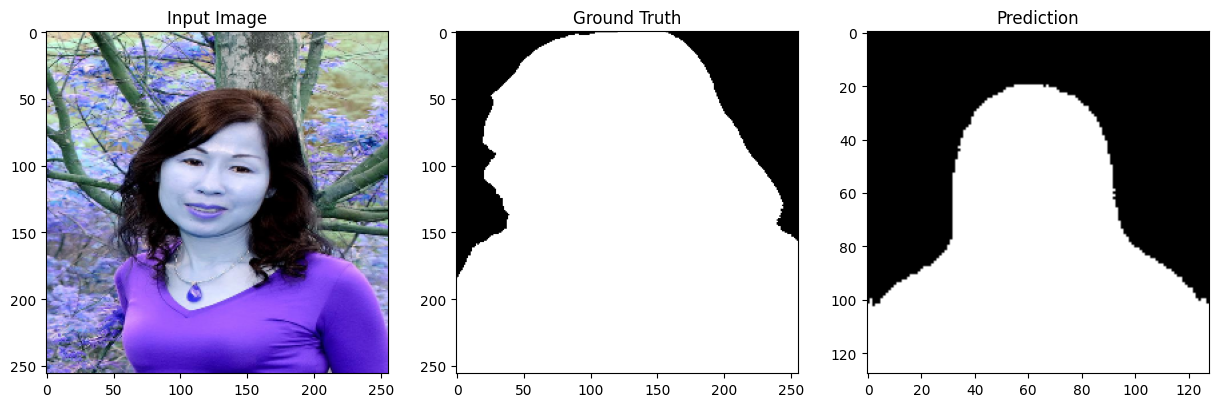

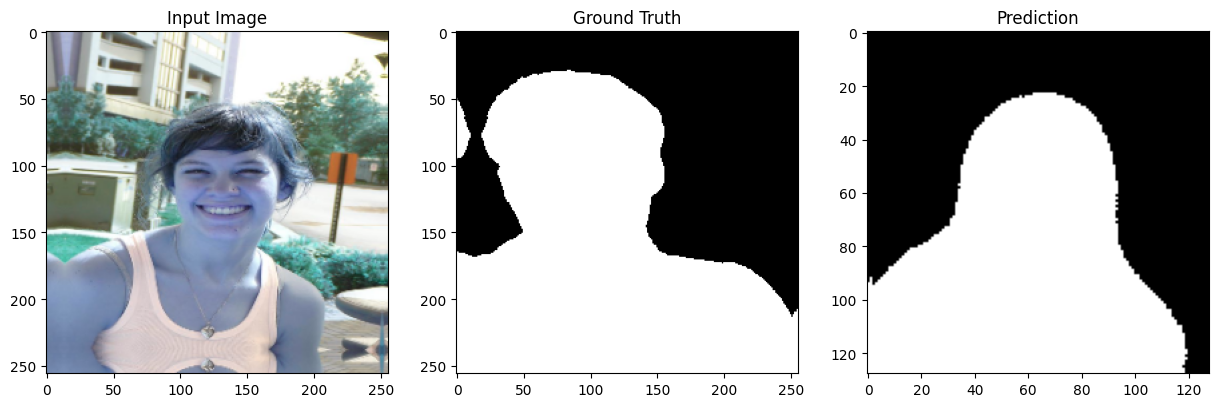

In [ ]:
model.eval()
fold_jaccard_scores = []
with torch.no_grad():
    for data in tqdm(test_loader):
        x = data['image'].to(device)
        y = data['mask'].to(device)
        outputs = model(x)
        outputs = nn.functional.interpolate(outputs, size=y.shape[2:], mode='bilinear', align_corners=False)
        preds = torch.sigmoid(outputs) > 0.5
        fold_jaccard_scores.append(jaccard_index(preds, y))

fold_avg_jaccard = np.mean(fold_jaccard_scores)
jaccard_scores.append(fold_avg_jaccard)
print(f'Jaccard Index: {fold_avg_jaccard:.4f}')


model.eval()
bound = 10
for i, data in tqdm(enumerate(test_loader), total=bound):
    if i == bound:
      break
    x = data['image'].to(device)
    y = data['mask'].to(device)
    with torch.no_grad():
        pred = torch.sigmoid(model(x)) > 0.5

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow((x[0].float()).permute(1, 2, 0).cpu())

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(y[0][0].cpu(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(pred[0][0].cpu(), cmap='gray')


plt.show()

## Final results

In [63]:
import pandas as pd

pd.DataFrame([
    ("UNET Standard", 0.7667),
    ("UNET + Augmentations", 0.6767),
    ("UNET + Augmentations + Test time horizontal flip", 0.6771),
    ("UNET + ResNetEncoder", 0.7262)
], columns=['Name', 'Jaccard index'])

Name  Jaccard index
0                                     UNET Standard         0.7667
1                              UNET + Augmentations         0.6767
2  UNET + Augmentations + Test time horizontal flip         0.6771
3                              UNET + ResNetEncoder         0.7262